<center><h1 style="font-size:3em"> COVID-19 au Sénégal </h1></center>

In [1]:
# Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Compare to Netherlands
import requests
from bs4 import BeautifulSoup

# Find coordinates
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="myapp2")
import time

# Plot static maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot interactive maps
import geopandas as gpd
from shapely import wkt
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, ColumnDataSource
import json
from bokeh.models import HoverTool

La table de donnée ci-dessous a été contruite à partir des tweets du Ministère de la Santé et de l'Action Sociale du Sénégal. La source peut être trouvée ici: https://twitter.com/MinisteredelaS1

# I. Imports

In [2]:
df = pd.read_csv("COVID_Dakar.csv", sep=";")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head(10)

,Date,Positif,Negatif,Age,Homme,Femme,Décédé,Guéri,Nationalité,Resident Senegal,Ville,Facteur,Source/Voyage,Hopital,Temps Hospitalisation (j)
0,2020-03-02,1,0,68.0,1.0,0.0,0.0,1.0,France,Oui,Dakar,Importé,France,FANN,4.0
1,2020-03-03,0,1,NaN,1.0,0.0,0.0,0.0,Gambie,Non,Dakar,Importé,Espagne,FANN,NaN
2,2020-03-03,1,0,80.0,1.0,0.0,0.0,1.0,France,Non,Dakar,Importé,France,FANN,10.0
3,2020-03-04,1,0,68.0,0.0,1.0,0.0,1.0,France,Non,Dakar,Importé,France,FANN,15.0
4,2020-03-04,1,0,33.0,0.0,1.0,0.0,1.0,Angleterre,Non,Dakar,Importé,Angleterre,FANN,7.0
5,2020-03-06,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dakar,NaN,NaN,NaN,NaN
6,2020-03-06,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dakar,NaN,NaN,NaN,NaN
7,2020-03-07,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dakar,NaN,NaN,NaN,NaN
8,2020-03-07,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dakar,NaN,NaN,NaN,NaN
9,2020-03-08,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dakar,NaN,NaN,NaN,NaN


# II. Exploration

## 1. Statistiques

In [3]:
evol_cases = df[['Date', 'Positif', 'Negatif', 'Décédé', 'Guéri']].groupby("Date").sum().cumsum()
evol_cases.head()

,Positif,Negatif,Décédé,Guéri
Date,,,,
2020-03-02,1.0,0.0,0.0,1.0
2020-03-03,2.0,1.0,0.0,2.0
2020-03-04,4.0,1.0,0.0,4.0
2020-03-06,4.0,3.0,0.0,4.0
2020-03-07,4.0,5.0,0.0,4.0


In [4]:
total_positif = evol_cases.tail(1)['Positif'][0]
total_negatif = evol_cases.tail(1)['Negatif'][0]
total_decede = evol_cases.tail(1)['Décédé'][0]
total_geuri = evol_cases.tail(1)['Guéri'][0]
print("Nombre de cas positifs: ", total_positif)
print("Nombre de cas negatifs: ", total_negatif)
print("Nombre de décès: ", total_decede)
print("Nombre de guérisons: ", total_geuri)

Nombre de cas positifs:  67.0
Nombre de cas negatifs:  255.0
Nombre de décès:  0.0
Nombre de guérisons:  5.0


In [11]:
evol_cases.tail()

,Positif,Negatif,Décédé,Guéri
Date,,,,
2020-03-18,36.0,92.0,0.0,5.0
2020-03-19,38.0,112.0,0.0,5.0
2020-03-20,47.0,159.0,0.0,5.0
2020-03-21,56.0,181.0,0.0,5.0
2020-03-22,67.0,255.0,0.0,5.0


In [30]:
growth = pd.DataFrame(np.sqrt(evol_cases['Positif'].pct_change(periods=2)+1)-1).tail(1)['Positif'][0]
growth

0.19395641247644257

Compare to Netherlands:

In [68]:
website_url = requests.get("https://en.wikipedia.org/wiki/2020_coronavirus_pandemic_in_the_Netherlands").text
soup = BeautifulSoup(website_url,"lxml")

In [69]:
My_table = soup.find("table",{"class":"wikitable mw-collapsible"})

In [104]:
df_nl = pd.read_html(str(My_table))[0]['Cases[b]']['Total'].apply(lambda x: x.replace("[c]", ""))[:-2].apply(lambda x: int(x))
df_nl = pd.DataFrame(df_nl)
df_nl['Date'] = pd.read_html(str(My_table))[0]['Date[a]']['Date[a]'][:-2]
df_nl['Date'] = pd.to_datetime(df_nl['Date'])

In [166]:
df_nl_2 = pd.DataFrame(np.concatenate([np.zeros(12), np.array(df_nl['Total'])]))
df_nl_2.columns = ["Netherlands"]

df_nl = pd.concat([pd.DataFrame(df_nl_2),pd.DataFrame(evol_cases.reset_index()['Positif'])], ignore_index=True, axis=1)

In [173]:
df_nl.columns = ['Netherlands', 'Senegal']
df_nl

,Netherlands,Senegal
0,0.0,1.0
1,0.0,2.0
2,0.0,4.0
3,0.0,4.0
4,0.0,4.0
5,0.0,4.0
6,0.0,4.0
7,0.0,4.0
8,0.0,5.0
9,0.0,10.0


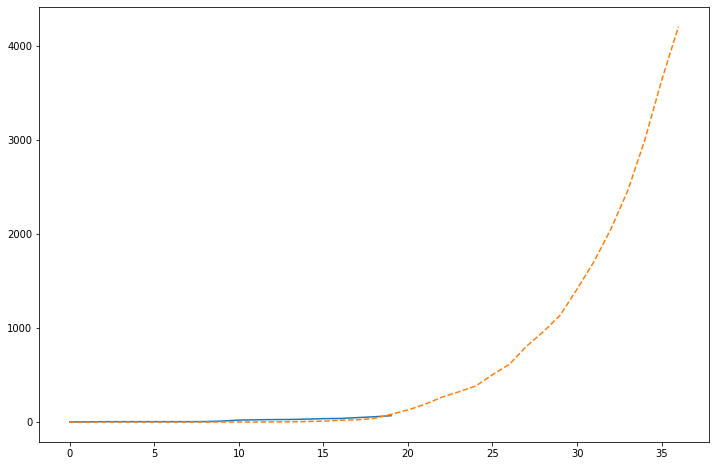

In [174]:
plt.figure(figsize=(12,8))
plt.plot(df_nl['Senegal'])
plt.plot(df_nl['Netherlands'], linestyle="--")
plt.show()

In [176]:
df_nl.to_csv("df_nl.csv")

## 2. Evolution du nombre de cas

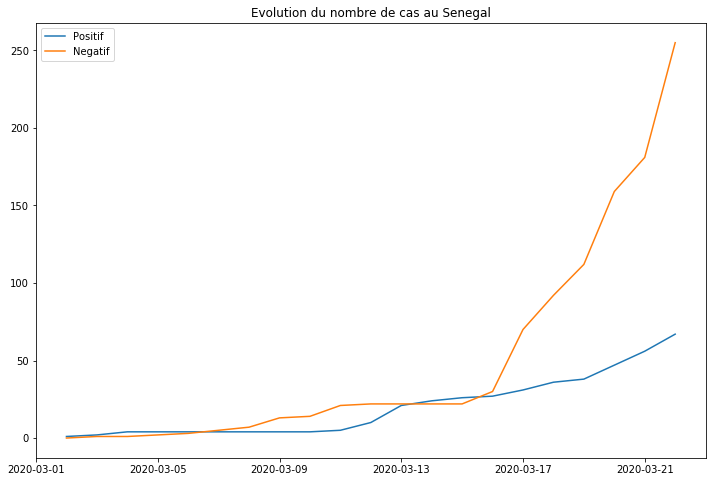

In [218]:
plt.figure(figsize=(12,8))
plt.plot(evol_cases['Positif'], label="Positif")
plt.plot(evol_cases['Negatif'], label="Negatif")
plt.legend()
plt.title("Evolution du nombre de cas au Senegal")
plt.show()

## 2. Age

In [219]:
np.mean(df['Age'].dropna())

48.9

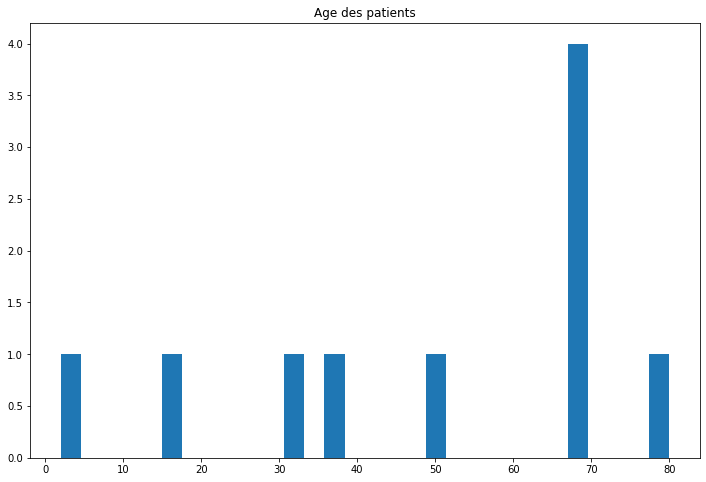

In [220]:
plt.figure(figsize=(12,8))
plt.hist(df['Age'].dropna(), bins=30)
plt.title("Age des patients")
plt.show()

## 3. Sexe

In [221]:
df[['Homme', 'Femme']].dropna().sum()

Homme    9.0
Femme    4.0
dtype: float64

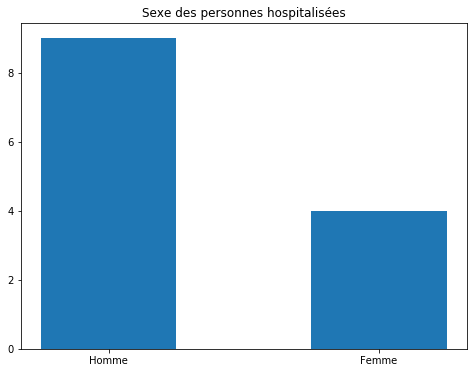

In [222]:
plt.figure(figsize=(8,6))
plt.bar(["Homme", "Femme"], df[['Homme', 'Femme']].dropna().sum(), width=0.5)
plt.title("Sexe des personnes hospitalisées")
plt.show()

## 4. Ville du cas

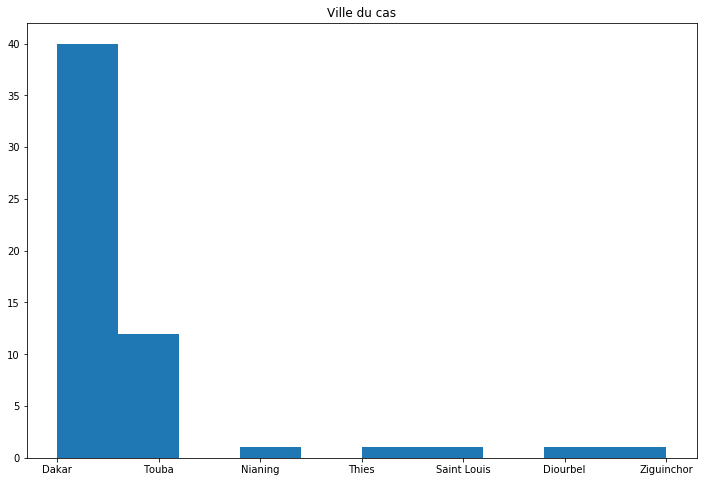

In [223]:
plt.figure(figsize=(12,8))
plt.hist(df['Ville'].dropna())
plt.title("Ville du cas")
plt.show()

## 5. Resident au Senegal

In [224]:
df['Resident Senegal'].dropna().value_counts()

Oui    22
Non     6
Name: Resident Senegal, dtype: int64

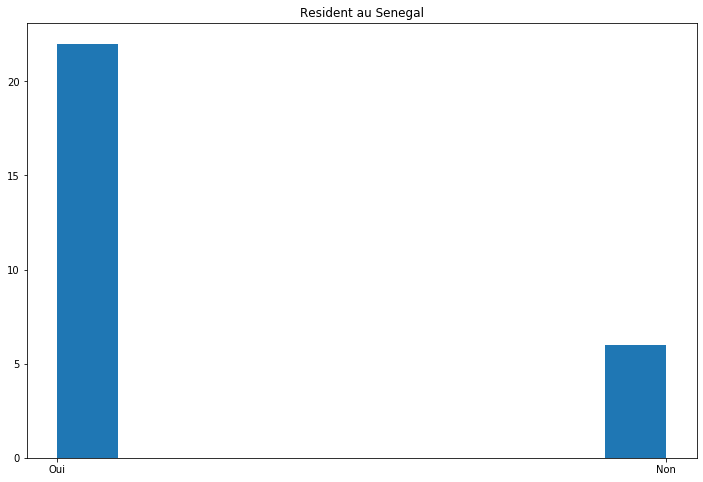

In [225]:
plt.figure(figsize=(12,8))
plt.hist(df['Resident Senegal'].dropna())
plt.title("Resident au Senegal")
plt.show()

## 6. Facteur de contamination

In [226]:
facteur = df[['Date', 'Facteur']].dropna()
facteur['Count'] = 1

importe = facteur[facteur['Facteur'] == "Importé"].groupby("Date").sum().cumsum().reset_index()
voyage = facteur[facteur['Facteur'] == "Contact"].groupby("Date").sum().cumsum().reset_index()

In [227]:
df_int = pd.merge(importe, voyage, left_on='Date', right_on='Date', how='outer')
df_int['Date'] = pd.to_datetime(df_int['Date'], dayfirst=True)
df_int = df_int.sort_values("Date").ffill().fillna(0)
df_int.columns = ["Date", "Importes", "Contact"]
df_int

,Date,Importes,Contact
0,2020-03-02,1.0,0.0
1,2020-03-03,3.0,0.0
2,2020-03-04,5.0,0.0
3,2020-03-11,6.0,0.0
13,2020-03-12,6.0,5.0
14,2020-03-13,6.0,16.0
4,2020-03-14,8.0,17.0
5,2020-03-15,9.0,18.0
6,2020-03-16,10.0,18.0
7,2020-03-17,13.0,19.0


In [228]:
alt.Chart(df_int).transform_fold(
    ['Importes', 'Contact'],
).mark_line().encode(
    x='Date:T',
    y='value:Q',
    color='key:N'
)

alt.Chart(...)

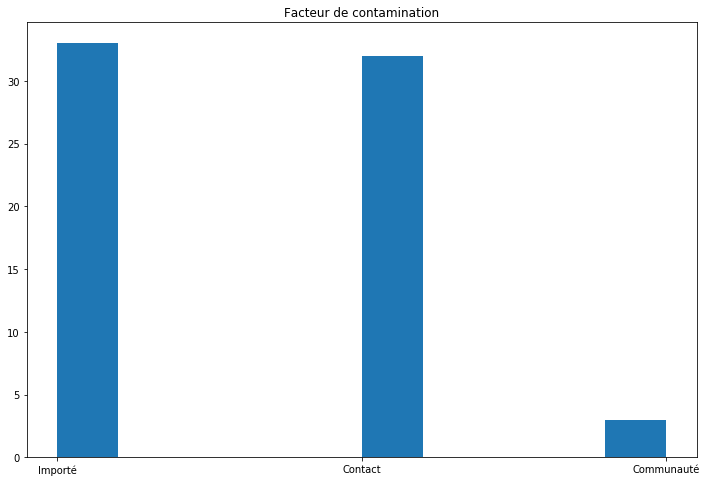

In [229]:
plt.figure(figsize=(12,8))
plt.hist(df['Facteur'].dropna())
plt.title("Facteur de contamination")
plt.show()

## 7. Source/Voyage

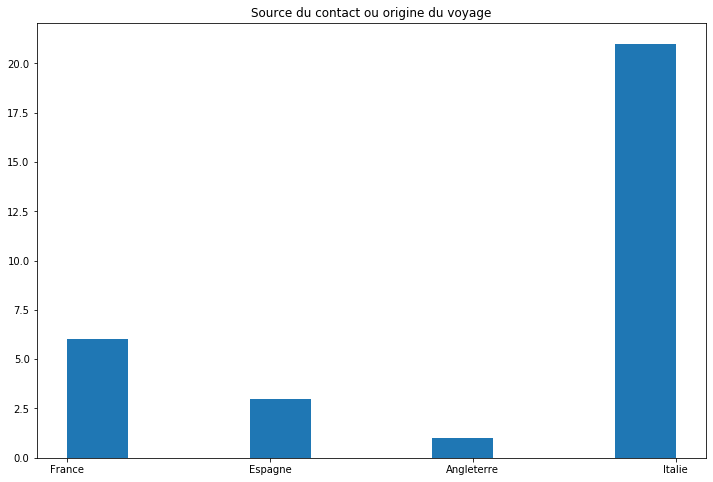

In [230]:
plt.figure(figsize=(12,8))
plt.hist(df['Source/Voyage'].dropna())
plt.title("Source du contact ou origine du voyage")
plt.show()

## 8. Source/Voyage

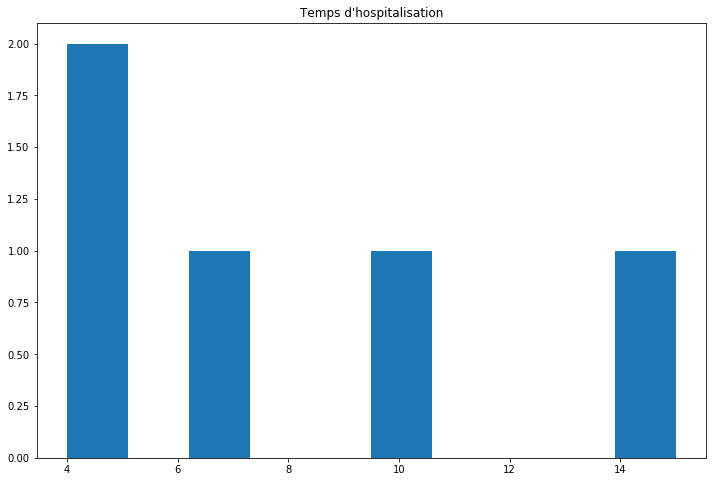

In [231]:
plt.figure(figsize=(12,8))
plt.hist(df['Temps Hospitalisation (j)'].dropna())
plt.title("Temps d'hospitalisation")
plt.show()

## 9. Carte

In [234]:
shapefile = 'app/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

In [235]:
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [236]:
gdf = gdf[gdf['country']=="Senegal"]

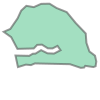

In [237]:
gdf['geometry'][51]

In [238]:
grid_crs=gdf.crs

#Read data to json.
gdf_json = json.loads(gdf.to_json())
#Convert to String like object.
grid = json.dumps(gdf_json)

In [239]:
latitude = []
longitude = []

for line in np.unique(df['Ville'].dropna()):
    location = geolocator.geocode(line + ", Senegal")

    latitude.append(location.latitude)
    longitude.append(location.longitude)
        
    time.sleep(3)

In [240]:
cities = pd.DataFrame([np.unique(df['Ville'].dropna()), latitude, longitude]).transpose()
cities.columns = ['Ville', 'Latitude', 'Longitude']

In [242]:
cities.to_csv("city_coordinates.csv")

In [87]:
def find_lat(x):
    try:
        return float(cities[cities['Ville'] == x]['Latitude'])
    except TypeError:
        return None

def find_long(x):
    try:
        return float(cities[cities['Ville'] == x]['Longitude'])
    except TypeError:
        return None

In [88]:
df

,Date,Positif,Negatif,Age,Homme,Femme,Décédé,Guéri,Nationalité,Resident Senegal,Ville,Facteur,Source/Voyage,Hopital,Temps Hospitalisation (j),latitude,longitude
0,2020-03-02,1,0,68.0,1.0,0.0,0.0,1.0,France,Oui,Dakar,Importé,France,FANN,4.0,14.693425,-17.447938
1,2020-03-03,0,1,NaN,1.0,0.0,0.0,0.0,Gambie,Non,Dakar,Importé,Espagne,FANN,NaN,14.693425,-17.447938
2,2020-03-03,1,0,80.0,1.0,0.0,0.0,1.0,France,Non,Dakar,Importé,France,FANN,10.0,14.693425,-17.447938
3,2020-03-04,1,0,68.0,0.0,1.0,0.0,1.0,France,Non,Dakar,Importé,France,FANN,15.0,14.693425,-17.447938
4,2020-03-04,1,0,33.0,0.0,1.0,0.0,1.0,Angleterre,Non,Dakar,Importé,Angleterre,FANN,7.0,14.693425,-17.447938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201,2020-03-21,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202,2020-03-21,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
203,2020-03-21,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
204,2020-03-21,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
summary = df[['Positif', 'Ville']].groupby("Ville").sum().reset_index()
summary['latitude'] = summary['Ville'].apply(lambda x: find_lat(x))
summary['longitude'] = summary['Ville'].apply(lambda x: find_long(x))

In [90]:
summary

,Ville,Positif,latitude,longitude
0,Dakar,29,14.693425,-17.447938
1,Nianing,1,14.343980,-16.929427
2,Touba,12,14.864559,-15.876047


In [91]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = grid)
pointsource = ColumnDataSource(summary)

hover = HoverTool(
    tooltips = [('Ville', '@Ville'), ('Nombre de cas positifs', '@Positif')]
)

#Create figure object.
p = figure(title = 'Cas au Sénégal', plot_height = 600 , plot_width = 950, tools=[hover, 'pan', 'wheel_zoom'])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

patch=p.patches('xs','ys', source = geosource,fill_color = '#fff7bc',
          line_color = 'black', line_width = 0.35, fill_alpha = 1, 
                hover_fill_color="#fec44f")

#Add patch renderer to figure. 
patch = p.patches('xs','ys', source = geosource, fill_color = 'lightgrey',
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#p.add_tools(HoverTool(tooltips=[('Confirmed cases','@cas_confirmes'),('Deaths','@deces'), ('Reanimation','@reanimation')], renderers=[patch]))

p.circle('longitude','latitude',source=pointsource, size='Positif')
#Display figure inline in Jupyter Notebook.

output_notebook()
#Display figure.
show(p)

Loading BokehJS ...

In [211]:
df2 = df[(df['country']=="Italy") | (df['country']=="Senegal") | (df['country']=="United Kingdom") | (df['country']=="France") | (df['country']=="Spain")]

In [213]:
import plotly.express as px
df = px.data.gapminder().query("year == 2007")

fig = px.line_geo(df2, locations="iso_alpha",
                  projection="orthographic")

fig.show()

In [175]:
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.828,31889923,974.580338,AFG,4
23,Albania,Europe,2007,76.423,3600523,5937.029526,ALB,8
35,Algeria,Africa,2007,72.301,33333216,6223.367465,DZA,12
47,Angola,Africa,2007,42.731,12420476,4797.231267,AGO,24
59,Argentina,Americas,2007,75.320,40301927,12779.379640,ARG,32
...,...,...,...,...,...,...,...,...
1655,Vietnam,Asia,2007,74.249,85262356,2441.576404,VNM,704
1667,West Bank and Gaza,Asia,2007,73.422,4018332,3025.349798,PSE,275
1679,"Yemen, Rep.",Asia,2007,62.698,22211743,2280.769906,YEM,887
1691,Zambia,Africa,2007,42.384,11746035,1271.211593,ZMB,894
